In [79]:
ls

PlantDoc-Dataset/


In [80]:
pwd

'/home/wsuser/work'

In [81]:
!pip install keras==2.7.0
!pip install tensorflow==2.5.0

# Image Augmentation

In [82]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [83]:
train_datagen=ImageDataGenerator(rescale=1./255,zoom_range=0.2,horizontal_flip=True,vertical_flip=False)

In [84]:
test_datagen=ImageDataGenerator(rescale=1./255)

In [85]:
ls

PlantDoc-Dataset/


In [86]:
pwd

'/home/wsuser/work'

In [87]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='kd5eBcEmb7JJzWSXkYlPmUw2UY5ZVWDZENSIy9s3bnzg',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'fertilizerrecommendation-donotdelete-pr-let4go6j2nmgdu'
object_key = 'PlantDoc-Dataset.zip'

streaming_body_3 = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/


In [88]:
from io import BytesIO
import zipfile
unzip = zipfile.ZipFile(BytesIO(streaming_body_3.read()), "r")
file_paths = unzip.namelist() 
for path in file_paths:
    unzip.extract(path)

In [89]:
pwd

'/home/wsuser/work'

In [90]:
import os
filenames = os.listdir('/home/wsuser/work/PlantDoc-Dataset/train')

In [91]:
x_train=train_datagen.flow_from_directory("/home/wsuser/work/PlantDoc-Dataset/train",target_size=(128,128),class_mode='categorical',batch_size=24)

Found 2316 images belonging to 27 classes.


In [92]:
x_test=test_datagen.flow_from_directory(r"/home/wsuser/work/PlantDoc-Dataset/test",target_size=(128,128),
                                        class_mode='categorical',batch_size=24)

Found 236 images belonging to 27 classes.


In [93]:
x_train.class_indices

{'Apple Scab Leaf': 0,
 'Apple leaf': 1,
 'Apple rust leaf': 2,
 'Bell_pepper leaf': 3,
 'Bell_pepper leaf spot': 4,
 'Blueberry leaf': 5,
 'Cherry leaf': 6,
 'Corn Gray leaf spot': 7,
 'Corn leaf blight': 8,
 'Corn rust leaf': 9,
 'Peach leaf': 10,
 'Potato leaf early blight': 11,
 'Potato leaf late blight': 12,
 'Raspberry leaf': 13,
 'Soyabean leaf': 14,
 'Squash Powdery mildew leaf': 15,
 'Strawberry leaf': 16,
 'Tomato Early blight leaf': 17,
 'Tomato Septoria leaf spot': 18,
 'Tomato leaf': 19,
 'Tomato leaf bacterial spot': 20,
 'Tomato leaf late blight': 21,
 'Tomato leaf mosaic virus': 22,
 'Tomato leaf yellow virus': 23,
 'Tomato mold leaf': 24,
 'grape leaf': 25,
 'grape leaf black rot': 26}

# CNN

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Convolution2D,MaxPooling2D,Flatten

In [95]:
model=Sequential()

In [96]:
model.add(Convolution2D(32,(3,3),input_shape=(128,128,3),activation='relu'))

In [97]:
model.add(MaxPooling2D(pool_size=(2,2)))

In [98]:
model.add(Flatten())

In [99]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 127008)            0         
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


In [100]:
32*(3*3*3+1)

896

# Hidden Layers

In [101]:
model.add(Dense(300,activation='relu'))
model.add(Dense(150,activation='relu'))

# Output Layer

In [102]:
model.add(Dense(6,activation='softmax'))

In [103]:
len(x_train)

97

In [104]:
1238/24

51.583333333333336

In [105]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [111]:
model.fit(x_train,steps_per_epoch=len(x_train),validation_data=x_test,validation_steps=len(x_test),epochs=10)

Epoch 1/10


InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[24,6] labels_size=[24,27]
	 [[node categorical_crossentropy/softmax_cross_entropy_with_logits (defined at tmp/wsuser/ipykernel_237/2778050854.py:1) ]] [Op:__inference_train_function_3563]

Function call stack:
train_function


# Saving Model

In [112]:
ls

PlantDoc-Dataset/


In [113]:
model.save('fruit.h5')

In [114]:
!tar -zcvf Train-model_new.tgz fruit.h5

fruit.h5


In [115]:
ls -1

fruit.h5
PlantDoc-Dataset/
Train-model_new.tgz


# IBM Cloud Deployment Model 

In [116]:
!pip install watson-machine-learning-client --upgrade

     |████████████████████████████████| 538 kB 22.5 MB/s eta 0:00:01


In [135]:
from ibm_watson_machine_learning import APIClient

wml_credentials = {
                    "url": "https://us-south.ml.cloud.ibm.com",
                   "apikey":"ALHOuwqvCU9it75n1U14B3C606NF8YbjR3sqC3JAsbfr" 
                  }

client = APIClient(wml_credentials)

In [136]:
client = APIClient(wml_credentials)

In [137]:
def guid_from_space_name(client, space_name): 
    space = client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']["name"]==space_name)['metadata']['id'])

In [138]:
space_uid = guid_from_space_name(client,'Trainmodel') 
print("Space UID = " + space_uid)

Space UID = 5dc1b38f-fcca-438b-a343-f756a1915100


In [139]:
client.set.default_space(space_uid)

'SUCCESS'

In [140]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt22.2-py3.10        125b6d9

In [144]:
software_space_uid = client.software_specifications.get_uid_by_name("tensorflow_rt22.1-py3.9")
#software_spec_uid

In [145]:
 ls

fruit.h5  PlantDoc-Dataset/  Train-model_new.tgz


In [147]:
model_details = client.repository.store_model(model= 'Train-model_new.tgz',
    meta_props={
        client.repository.ModelMetaNames.NAME:"CNN",
        client.repository.ModelMetaNames.TYPE:"tensorflow_2.7",
        client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_space_uid}
    )


In [148]:
model_id = client.repository.get_model_id(model_details)

In [149]:
model_id

'ed3b65fe-966d-4648-8321-27a6f23266c2'

In [150]:
ls

fruit.h5  PlantDoc-Dataset/  Train-model_new.tgz


# Test The Model

In [151]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [152]:
model=load_model('fruit.h5')

In [154]:
img=image.load_img(r'/home/wsuser/work/PlantDoc-Dataset/test/Apple Scab Leaf/Apple Scab Leaf (2).jpg')
# In[ ]:

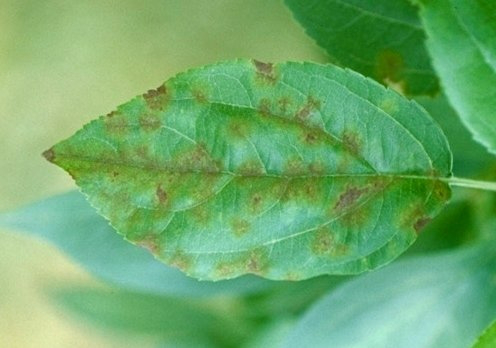

In [155]:
img

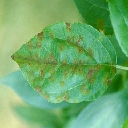

In [162]:
img=image.load_img(r"/home/wsuser/work/PlantDoc-Dataset/test/Apple Scab Leaf/Apple Scab Leaf (2).jpg",target_size=(128,128))
img

In [163]:
x=image.img_to_array(img)

In [164]:
x

array([[[152., 178., 105.],
        [152., 180., 106.],
        [147., 179., 106.],
        ...,
        [ 29., 123.,   9.],
        [ 25., 119.,   7.],
        [ 28., 117.,   7.]],

       [[151., 177., 104.],
        [151., 179., 105.],
        [148., 180., 107.],
        ...,
        [ 25., 115.,   1.],
        [ 32., 125.,  11.],
        [ 30., 117.,   4.]],

       [[154., 180., 107.],
        [150., 178., 104.],
        [148., 180., 107.],
        ...,
        [ 31., 119.,   6.],
        [ 36., 125.,   9.],
        [ 26., 113.,   0.]],

       ...,

       [[216., 223., 156.],
        [213., 219., 157.],
        [215., 219., 158.],
        ...,
        [ 86., 177.,  37.],
        [ 84., 176.,  41.],
        [101., 192.,  61.]],

       [[214., 221., 154.],
        [215., 221., 157.],
        [219., 223., 162.],
        ...,
        [ 89., 182.,  42.],
        [ 90., 181.,  50.],
        [ 95., 188.,  56.]],

       [[214., 221., 153.],
        [215., 221., 157.],
        [218., 2

In [165]:
x=np.expand_dims(x,axis=0)

In [166]:
x

array([[[[152., 178., 105.],
         [152., 180., 106.],
         [147., 179., 106.],
         ...,
         [ 29., 123.,   9.],
         [ 25., 119.,   7.],
         [ 28., 117.,   7.]],

        [[151., 177., 104.],
         [151., 179., 105.],
         [148., 180., 107.],
         ...,
         [ 25., 115.,   1.],
         [ 32., 125.,  11.],
         [ 30., 117.,   4.]],

        [[154., 180., 107.],
         [150., 178., 104.],
         [148., 180., 107.],
         ...,
         [ 31., 119.,   6.],
         [ 36., 125.,   9.],
         [ 26., 113.,   0.]],

        ...,

        [[216., 223., 156.],
         [213., 219., 157.],
         [215., 219., 158.],
         ...,
         [ 86., 177.,  37.],
         [ 84., 176.,  41.],
         [101., 192.,  61.]],

        [[214., 221., 154.],
         [215., 221., 157.],
         [219., 223., 162.],
         ...,
         [ 89., 182.,  42.],
         [ 90., 181.,  50.],
         [ 95., 188.,  56.]],

        [[214., 221., 153.],
       

In [167]:
y=np.argmax(model.predict(x),axis=1)

In [168]:
x_train.class_indices

{'Apple Scab Leaf': 0,
 'Apple leaf': 1,
 'Apple rust leaf': 2,
 'Bell_pepper leaf': 3,
 'Bell_pepper leaf spot': 4,
 'Blueberry leaf': 5,
 'Cherry leaf': 6,
 'Corn Gray leaf spot': 7,
 'Corn leaf blight': 8,
 'Corn rust leaf': 9,
 'Peach leaf': 10,
 'Potato leaf early blight': 11,
 'Potato leaf late blight': 12,
 'Raspberry leaf': 13,
 'Soyabean leaf': 14,
 'Squash Powdery mildew leaf': 15,
 'Strawberry leaf': 16,
 'Tomato Early blight leaf': 17,
 'Tomato Septoria leaf spot': 18,
 'Tomato leaf': 19,
 'Tomato leaf bacterial spot': 20,
 'Tomato leaf late blight': 21,
 'Tomato leaf mosaic virus': 22,
 'Tomato leaf yellow virus': 23,
 'Tomato mold leaf': 24,
 'grape leaf': 25,
 'grape leaf black rot': 26}

In [169]:
index=['Apple___Black_rot','Apple___healthy','Corn_(maize)___Northern_Leaf_Blight','Corn_(maize)___healthy','Peach___Bacterial_spot','Peach___healthy']


In [170]:
index[y[0]]

'Peach___healthy'